# 适度冒险因子
由于本因子需要用到分钟级别的量价数据，全部得到数据量太大，难以通过邮件发送。

因此，我只选取了其中300只股票2021年的数据进行简单的实现。

# 数据准备

In [1]:
import pandas as pd
import json
import os
import zipfile
import numpy as np
from tqdm import tqdm
from quantools import backtest
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("../data/stock_pool.json", 'r') as f:
    stock_pool = json.load(f)
len(stock_pool)

299

In [4]:
# close:  收盘价
# volume: 交易量
# stock_code: 股票代码
# date: 交易日期
# hour: 交易小时
# minute: 交易分钟
# rtn: 收益率
# volume_delta: 交易量变化情况

def dataloader(stock_code):
    with zipfile.ZipFile("../data/mins.zip", 'r') as zfile:
        f = zfile.open(f'mins/{stock_code}.csv')
        df = pd.read_csv(f)
    df['rtn'] = df.groupby('date').apply(lambda x: (x['close']-x['close'].shift(1)) / x['close'].shift(1)).reset_index(drop=True)
    df['date'] = pd.to_datetime(df['date'])
    return df

df = dataloader("000001.SZ")
df.head()

,close,volume,stock_code,date,hour,minute,rtn
0,2853.1013,3887508,000001.SZ,2021-01-04,9,31,NaN
1,2847.0500,1843936,000001.SZ,2021-01-04,9,32,-0.002121
2,2850.0757,1673800,000001.SZ,2021-01-04,9,33,0.001063
3,2824.3584,2422714,000001.SZ,2021-01-04,9,34,-0.009023
4,2813.7690,2531900,000001.SZ,2021-01-04,9,35,-0.003749


In [154]:
# stock_code: 股票代码
# date: 交易日期
# open: 开盘价
# high: 最高价
# low: 最低价
# close: 收盘价
# pre_close: 前收盘价
# volume: 交易量

daily_stock_data = pd.read_csv("../data/daily_stock_data.csv")
daily_stock_data['date'] = pd.to_datetime(daily_stock_data['date'])
daily_stock_data['rtn'] = (daily_stock_data['close'] - daily_stock_data['pre_close']) / daily_stock_data['pre_close']
daily_stock_data.head(5)

,stock_code,date,open,high,low,close,pre_close,volume,rtn
0,000001.SZ,2021-12-31,16.86,16.90,16.40,16.48,16.82,1750760.89,-0.020214
1,000001.SZ,2021-12-30,16.76,16.95,16.72,16.82,16.75,796663.60,0.004179
2,000001.SZ,2021-12-29,17.16,17.16,16.70,16.75,17.17,1469373.98,-0.024461
3,000001.SZ,2021-12-28,17.22,17.33,17.09,17.17,17.22,1126638.91,-0.002904
4,000001.SZ,2021-12-27,17.33,17.35,17.16,17.22,17.31,731118.99,-0.005199


# 计算预测收益

In [56]:
dsd = {}
for key in tqdm(['high', 'open', 'low', 'close', 'volume']):
    dsd[key] = pd.pivot(daily_stock_data, index='date', columns='stock_code', values=key)

dsd['pred_rtn'] = (dsd['close'].shift(-1)-dsd['close'])/dsd['close']

pred_rtn_na = dsd['pred_rtn'].isna() # 不要把空值变成0

# 明天停牌的股票只能获得0的收益
vol0 = dsd['volume'].shift(-1)==0
dsd['pred_rtn'][vol0 & (~pred_rtn_na)] = 0 

# 明天一字涨停的股票无法买入，只能获得0的收益
yz = dsd['high'].shift(-1)==dsd['low'].shift(-1) # “一字”，价格没有变化
zt = ~(dsd['close'].shift(-1) > dsd['close']) # “涨停”，价格不比上周高
dsd['pred_rtn'][yz & zt & (~pred_rtn_na)] = 0 

pred_rtn = dsd['pred_rtn'].stack().reset_index().rename(columns={0: 'pred_rtn'})

100%|██████████| 5/5 [00:00<00:00, 27.85it/s]


# 因子计算
因子计算思路：

计算分钟频率交易量的变化: $\Delta volume = volume_t-volume_{t-1}$

由此得到每日放量的“激增时刻”: $t_s = \Delta volume>\overline{\Delta volume}+\sigma (\Delta volume)?0:1$

分别计算激增时刻后五分钟收益率的平均值，标准差作为这个激增时刻所引起的市场反应的“耀眼收益率$r_s$”与”“耀眼波动率\sigma_s”

分别计算t日所有激增时刻的“耀眼收益率$r_s$”与”“耀眼波动率\sigma_s”的均值，作为“日耀眼收益率$r_s^t$”与“日耀眼波动率\sigma_s^t”

计算二者在截面上的均值作为当日的“适度水平”，计算两个日度指标与市场平均水平的差距，然后计算差距的均值作为“月均耀眼指标”，标准差作为“月稳耀眼指标”。

最后：

$$
月耀眼收益率 = 月均耀眼收益率 + 月稳耀眼收益率 \\
月耀眼波动率 = 月均耀眼波动率 + 月稳耀眼波动率
$$

## 激增时刻

In [52]:
def find_surge_time(stk_data):
    """
        识别每日交易过程中的“激增时刻”，即交易量超过当天交易量增量mean+std的时刻
    Args:
        stk_data (_type_): 单只股票的分钟序列

    Returns:
        _type_: _description_
    """
    stk_data['volume_delta'] = stk_data.groupby(['stock_code', 'date']) \
        .apply(lambda x: x['volume']-x['volume'].shift(1)).reset_index(drop=True)
    up_bound = stk_data.groupby(['stock_code', 'date'])['volume_delta'] \
        .apply(lambda x: x.mean()+x.std()).reset_index() \
        .rename(columns={"volume_delta": 'up_bound'})
    stk_data = pd.merge(stk_data, up_bound, on=['stock_code', 'date'], how="left")

    stk_data['surge'] = 0
    stk_data.loc[stk_data['volume_delta']>stk_data['up_bound'], 'surge'] = 1
    return stk_data

In [7]:
ls = []
for stock_code in tqdm(stock_pool):
    stk_data = dataloader(stock_code)
    ls.append(stk_data)
stk_data = pd.concat(ls).reset_index(drop=True)
stk_data = find_surge_time(stk_data)

100%|██████████| 299/299 [01:04<00:00,  4.63it/s]


## 因子计算

In [141]:
def calculate_moderate_risk_factor(stk_data0):
    """
        计算适度冒险因子
    Args:
        stk_data (_type_): 股票数据
    """
    def monthly_excellent_factor(stk_data, aspect):
        """
        计算股票不同指标月度情况
        """
        # 激增时刻后五分钟内收益率指标的均值
        stk_data.loc[stk_data['surge']==0][aspect] = np.nan
        fac_ex = stk_data.groupby(['stock_code', 'date'], group_keys=False)[aspect] \
            .apply(lambda x: x.mean()).to_frame() \
            .rename(columns={aspect: 'excellent'}).reset_index()
        
        # 以截面均值为适度水平，计算每只股票与适度水平的距离
        market_level = fac_ex.groupby('date')['excellent'] \
            .mean().to_frame().rename(columns={'excellent': 'market_level'})
        fac_ex = pd.merge(fac_ex, market_level, on="date", how='left')
        fac_ex['moderate'] = abs(fac_ex['excellent'] - fac_ex['market_level'])
        fac_ex = fac_ex.set_index('date')
        # 分别讨论距离的均值与波动率
        factor = pd.DataFrame()
        factor['moderate_mean'] = fac_ex.groupby('stock_code')['moderate'].rolling(20).mean() # 月均耀眼指标
        factor['moderate_std'] = fac_ex.groupby('stock_code')['moderate'].rolling(20).std()# 月稳耀眼指标
        factor['factor'] = factor['moderate_mean'] + factor['moderate_std']
        return factor[['factor']]

    # 计算激增时刻后五分钟内收益率的均值与标准差
    stk_data = stk_data0.copy()
    stk_data['rtn_m5'] = stk_data.groupby(['stock_code', 'date'], group_keys=False)['rtn'] \
        .apply(lambda x: x.rolling(5).mean().shift(-5))
    stk_data['rtn_s5'] = stk_data.groupby(['stock_code', 'date'], group_keys=False)['rtn'] \
        .apply(lambda x: x.rolling(5).std().shift(-5))
    
    # 等比例相加，形成适度冒险因子
    fac_ex_ret = monthly_excellent_factor(stk_data, "rtn_m5")
    fac_ex_vol = monthly_excellent_factor(stk_data, "rtn_s5")
    factor = (fac_ex_ret['factor'] + fac_ex_vol['factor']).reset_index()
    return factor

## 因子数据处理

In [142]:
factor = calculate_moderate_risk_factor(stk_data)
factor = factor.dropna()

In [145]:
factor = pd.merge(factor, pred_rtn, on=['date', 'stock_code'], how='left')
factor = factor[~factor['pred_rtn'].isna()].rename(columns={'factor': "moderate_risk_factor", 'date': "close_date"})

In [146]:
factor = backtest.winsorize_factor(factor, 'moderate_risk_factor')

Winsorizing the factor moderate_risk_factor: 100%|██████████| 71730/71730 [00:01<00:00, 46558.53it/s]


In [149]:
factor.head(5)

,stock_code,close_date,moderate_risk_factor,pred_rtn
5651,000001.SZ,2021-01-29,0.000551,0.063231
5652,000002.SZ,2021-01-29,0.001112,0.010076
5653,000004.SZ,2021-01-29,0.000724,-0.055281
5654,000005.SZ,2021-01-29,0.001220,-0.093458
5655,000006.SZ,2021-01-29,0.000634,0.014403


# 因子检测

In [151]:
res_dict = backtest.fama_macbeth(factor, 'moderate_risk_factor')
fama_macbeth_res = pd.DataFrame([res_dict])
fama_macbeth_res

Fama-MacBeth Regression by factor moderate_risk_factor:   0%|          | 0/222 [00:00<?, ?it/s]

Fama-MacBeth Regression by factor moderate_risk_factor: 100%|██████████| 222/222 [00:00<00:00, 1025.78it/s]


,fac_name,t,p,pos_count,neg_count
0,moderate_risk_factor,0.189631,0.849773,113,109


Calculating groups: 100%|██████████| 10/10 [00:00<00:00, 108.99it/s]


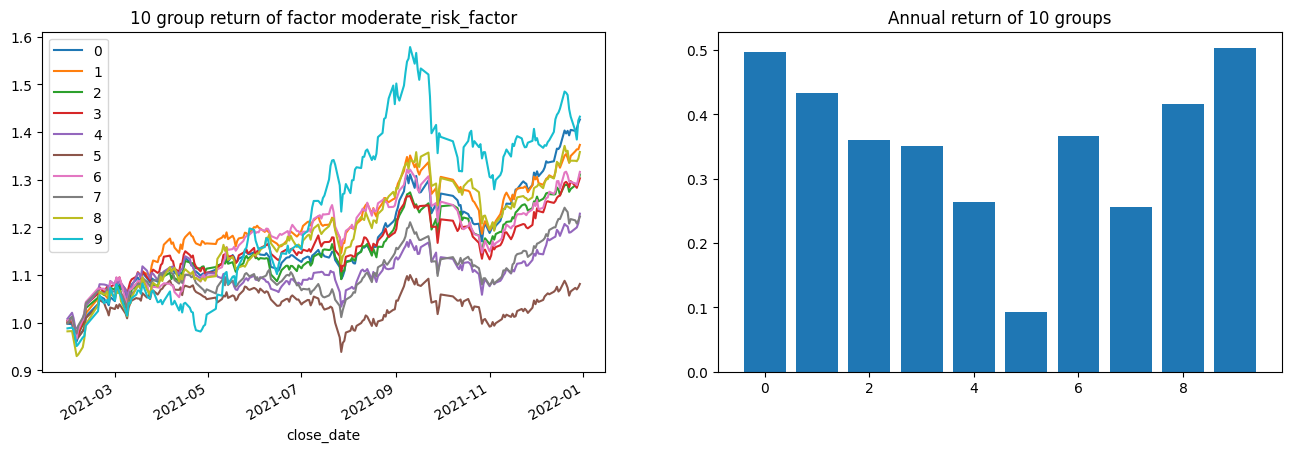

In [152]:
group_rtns, group_cum_rtns = backtest.group_return_analysis(factor, 'moderate_risk_factor')

整体来看该因子是一个正向因子，从我选择的回测期来看，这并不是一个有效的因子。

通过Fama-MacBeth检验，其带来的收益几乎为0，而且并不显著。

对因子进行分组回测可以看到，收益两头高中间低，可以进行进一步的优化。

但是由于回测时间太短，而且只在300只股票中测试，无法判定因子的真实效果，可能只是收到市场风格影响，可以在更长的时间，更大的票池上测试。

,sharpe_ratio,max_drawdown,max_drawdown_start,max_drawdown_end,sortino_ratio,annual_return,annual_volatility,section
0,1.930454,0.131483,2021-09-10,2021-11-04,2.777997,0.388784,0.178471,Sum
1,1.930454,0.131483,2021-09-10,2021-11-04,2.777997,0.388784,0.178471,2021


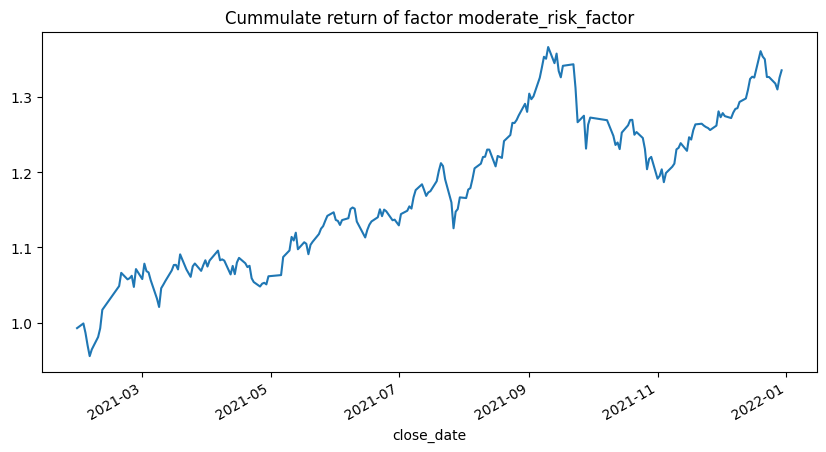

In [153]:
rtn, evaluate_result = backtest.backtest_1week_nstock(factor, 'moderate_risk_factor')
evaluate_result

从策略指标来看，效果其实还可以，夏普比接近2，回撤也较小。整体收益比300只股票的均值大一些。

In [163]:
market_rtn = daily_stock_data.groupby('date')['rtn'].mean().to_frame().rename(columns={'rtn': 'market_rtn'})
rtn = pd.merge(rtn, market_rtn, right_index=True, left_index=True, how="left")
rtn['market_cum_rtn'] = (1 + rtn['market_rtn']).cumprod()

<Axes: xlabel='close_date'>

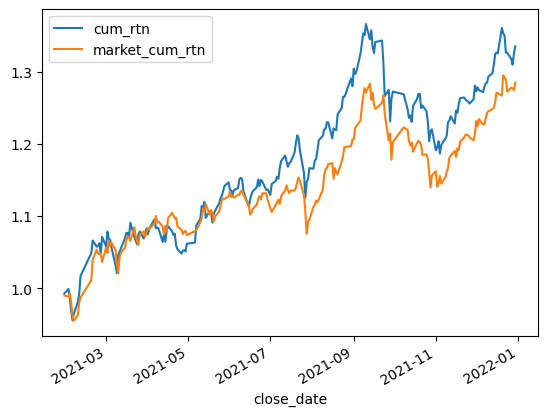

In [169]:
rtn[['cum_rtn', 'market_cum_rtn']].plot()